### Graph Previous Runs

In [10]:
import pickle

# load the graph data from train.ipynb
with open('base_run4.pkl', 'rb') as f:
    data = pickle.load(f)

episode_rewards = data['episode_rewards']
actor_losses = data['actor_losses']
critic_losses = data['critic_losses']
current_Q_means = data['current_Q_means']
target_Q_means = data['target_Q_means']

In [16]:
import numpy as np
batch_size = 200
avg_rewards = [np.mean(episode_rewards[i:i + batch_size]) for i in range(0, len(episode_rewards), batch_size)]
for i in range(5):
    output = " & ".join([str(round(avg_rewards[i], 2)) for i in range(5)]) # formatted like this for latex :P
print(output)


-315.97 & -95.12 & 181.05 & 177.36 & 163.73


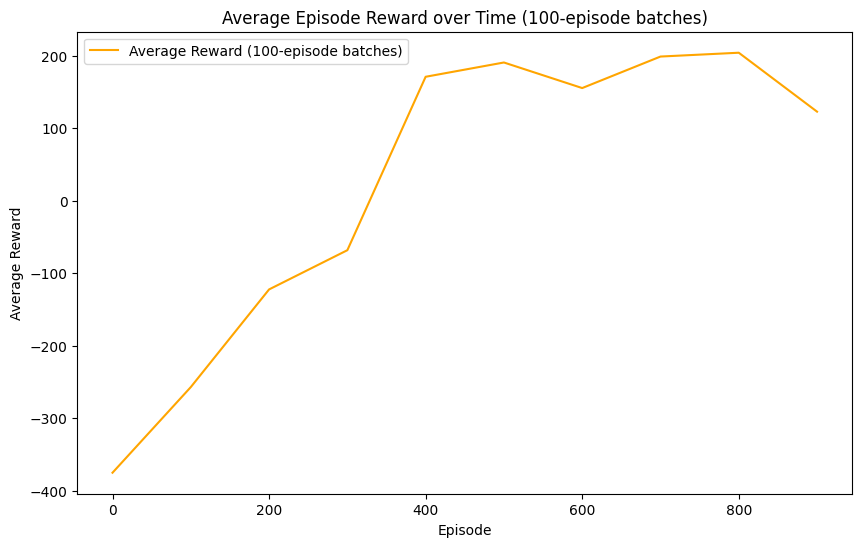

In [11]:
import numpy as np
import matplotlib.pyplot as plt

# split the data into samples of 100 episodes
batch_size = 100
average_rewards = [np.mean(episode_rewards[i:i + batch_size]) for i in range(0, len(episode_rewards), batch_size)]

# graph the average reward
plt.figure(figsize=(10, 6))
plt.plot(range(0, len(episode_rewards), batch_size), average_rewards, label="Average Reward (100-episode batches)", color='orange')
plt.title("Average Episode Reward over Time (100-episode batches)")
plt.xlabel("Episode")
plt.ylabel("Average Reward")
plt.legend()
plt.show()


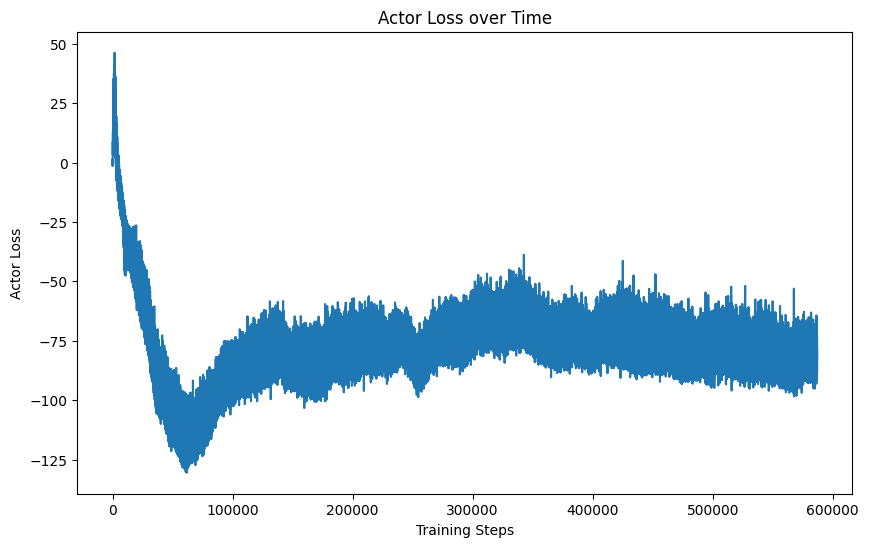

In [14]:
# plot demonstrating the actor's loss over time
plt.figure(figsize=(10, 6))
plt.plot(actor_losses)
plt.title("Actor Loss over Time")
plt.xlabel("Training Steps")
plt.ylabel("Actor Loss")
plt.show()

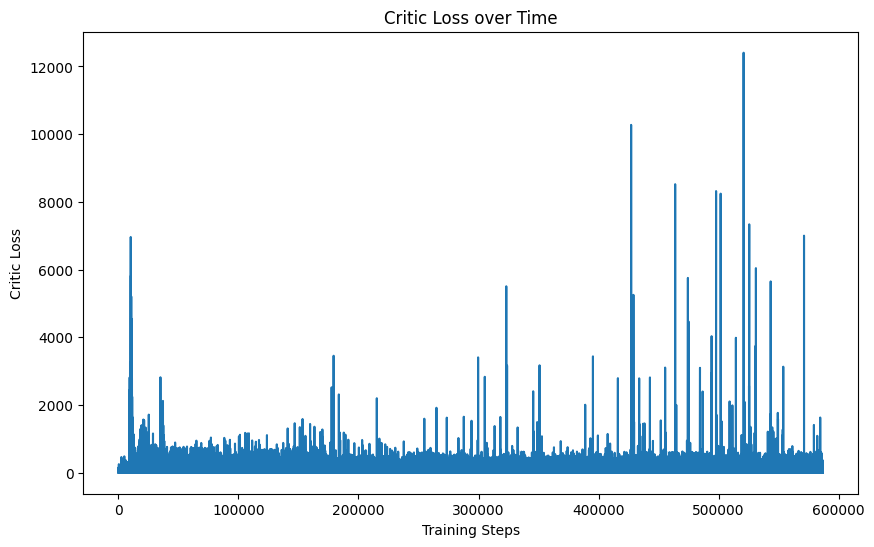

In [15]:
# plot demonstrating the critic's loss over time
plt.figure(figsize=(10, 6))
plt.plot(critic_losses)
plt.title("Critic Loss over Time")
plt.xlabel("Training Steps")
plt.ylabel("Critic Loss")
plt.show()

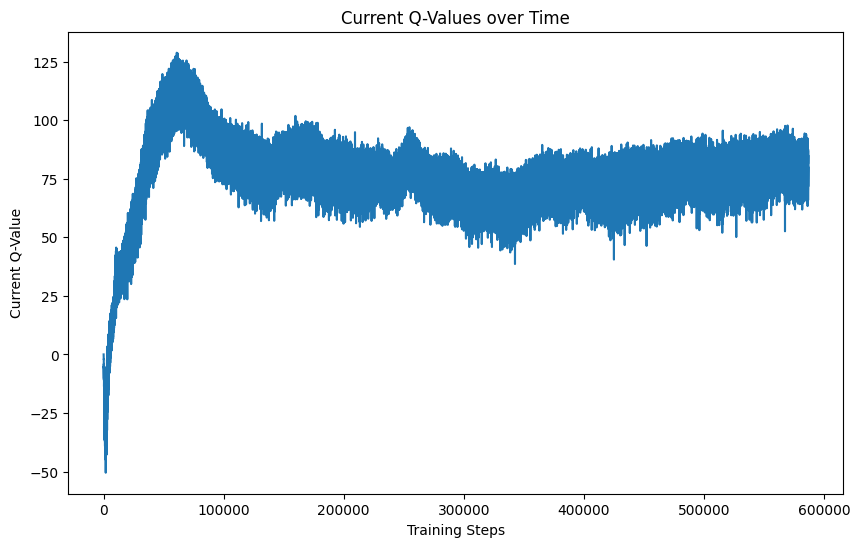

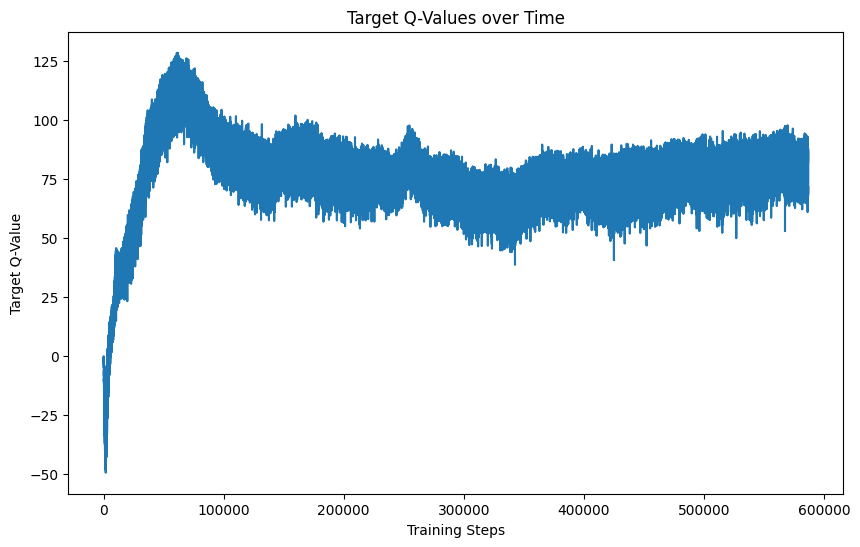

In [16]:
# these two plots show the current Q-Value next to the Q-Value we want to get to
plt.figure(figsize=(10, 6))
plt.plot(current_Q_means)
plt.title("Current Q-Values over Time")
plt.xlabel("Training Steps")
plt.ylabel("Current Q-Value")
plt.show()

plt.figure(figsize=(10, 6))
plt.plot(target_Q_means)
plt.title("Target Q-Values over Time")
plt.xlabel("Training Steps")
plt.ylabel("Target Q-Value")
plt.show()

### Test Single Previous Runs

In [1]:
import gymnasium as gym
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import random
from collections import deque

In [2]:
class Actor(nn.Module):
    def __init__(self, state_dimensions, action_dimensions, max_action):
        super(Actor, self).__init__()

        # first layer of the neural network, state_dimension amt of neurons to 256 neurons
        self.first_layer = nn.Linear(state_dimensions, 256)


        self.second_layer = nn.Linear(256, 256)

        # 256 neurons to action_dimension amt of neurons
        self.third_layer = nn.Linear(256, action_dimensions)

        # the scale of the action (-1, 1) for our purposes
        self.max_action = max_action


    def forward(self, state):
        # returns a "tensor" (a matrix with a single column) representing the output of the first layer
        x = torch.relu(self.first_layer(state))
        x = torch.relu(self.second_layer(x))

        # returns a tensor with one column and eight rows, each item represents the
        # continous action to take on a given control (left axis, right axis, etc)
        action = torch.tanh(self.third_layer(x)) * self.max_action
        return action

In [3]:
# initialize the env
human_env = gym.make("LunarLanderContinuous-v2")
state_dimensions = human_env.observation_space.shape[0]
action_dimensions = human_env.action_space.shape[0]
max_action = human_env.action_space.high[0]

# grab the actor to test
loaded_actor = Actor(state_dimensions, action_dimensions, max_action)
loaded_actor.load_state_dict(torch.load('test_013_actor.pth'))
loaded_actor.eval()

# and test
num_test_episodes = 100
total_reward = 0
for episode in range(num_test_episodes):

    state, _ = human_env.reset()
    episode_reward = 0
    done = False

    while not done:

        state_tensor = torch.FloatTensor(state).unsqueeze(0)

        with torch.no_grad():
            action = loaded_actor(state_tensor).numpy()[0]

        action = np.clip(action, -max_action, max_action)

        next_state, reward, done, _, info = human_env.step(action)
        episode_reward += reward

        state = next_state

    print(f"Test Episode: {episode + 1}, Reward: {episode_reward}")
    total_reward += episode_reward

print(f"Average Reward Over {num_test_episodes} Runs: {total_reward/num_test_episodes}")

human_env.close()


Test Episode: 1, Reward: 253.14242550761222
Test Episode: 2, Reward: 246.47856633158256
Test Episode: 3, Reward: 254.256284027096
Test Episode: 4, Reward: 255.7764503586092


KeyboardInterrupt: 

### Test Multiple Previous Runs

In [16]:
# Initialize the environment
human_env = gym.make("LunarLanderContinuous-v2")
state_dimensions = human_env.observation_space.shape[0]
action_dimensions = human_env.action_space.shape[0]
max_action = human_env.action_space.high[0]

# tests to test
test_list = ['230']
num_test_episodes = 1000

# storing the reward for more graphs!
test_rewards = {}

for test_name in test_list:
    loaded_actor = Actor(state_dimensions, action_dimensions, max_action)
    actor_filename = f'test_{test_name}_actor.pth'
    loaded_actor.load_state_dict(torch.load(actor_filename))
    loaded_actor.eval()
    
    total_reward = 0
    episode_rewards = []
    
    for episode in range(num_test_episodes):
        state, _ = human_env.reset()
        episode_reward = 0
        done = False

        while not done:
            state_tensor = torch.FloatTensor(state).unsqueeze(0)
            with torch.no_grad():
                action = loaded_actor(state_tensor).numpy()[0]
            action = np.clip(action, -max_action, max_action)
            next_state, reward, done, _, info = human_env.step(action)
            episode_reward += reward
            state = next_state
        print(f"Test {test_name} Episode: {episode + 1}, Reward: {episode_reward}")
        total_reward += episode_reward
        episode_rewards.append(episode_reward)
    average_reward = total_reward / num_test_episodes
    print(f"Test {test_name} Average Reward Over {num_test_episodes} Runs: {average_reward}")
    test_rewards[test_name] = episode_rewards

human_env.close()



Test 230 Episode: 1, Reward: 276.88090589472057
Test 230 Episode: 2, Reward: 279.74059130258433
Test 230 Episode: 3, Reward: 287.9624909839075
Test 230 Episode: 4, Reward: 257.4756322532515
Test 230 Episode: 5, Reward: 277.7448872829245
Test 230 Episode: 6, Reward: 302.5801020001806
Test 230 Episode: 7, Reward: 243.091346838848
Test 230 Episode: 8, Reward: 285.86095738073357
Test 230 Episode: 9, Reward: 252.06448113828682
Test 230 Episode: 10, Reward: 268.79590577920055
Test 230 Episode: 11, Reward: 239.63382634618537
Test 230 Episode: 12, Reward: 259.2574808790388
Test 230 Episode: 13, Reward: 284.7962205306861
Test 230 Episode: 14, Reward: 252.42637863072295
Test 230 Episode: 15, Reward: 288.02107671555916
Test 230 Episode: 16, Reward: 280.2144806800826
Test 230 Episode: 17, Reward: 141.4424146659338
Test 230 Episode: 18, Reward: 285.87469812191364
Test 230 Episode: 19, Reward: 269.1993443228364
Test 230 Episode: 20, Reward: 263.472665293494
Test 230 Episode: 21, Reward: 272.02228186

### Graph Multiple Previous Runs

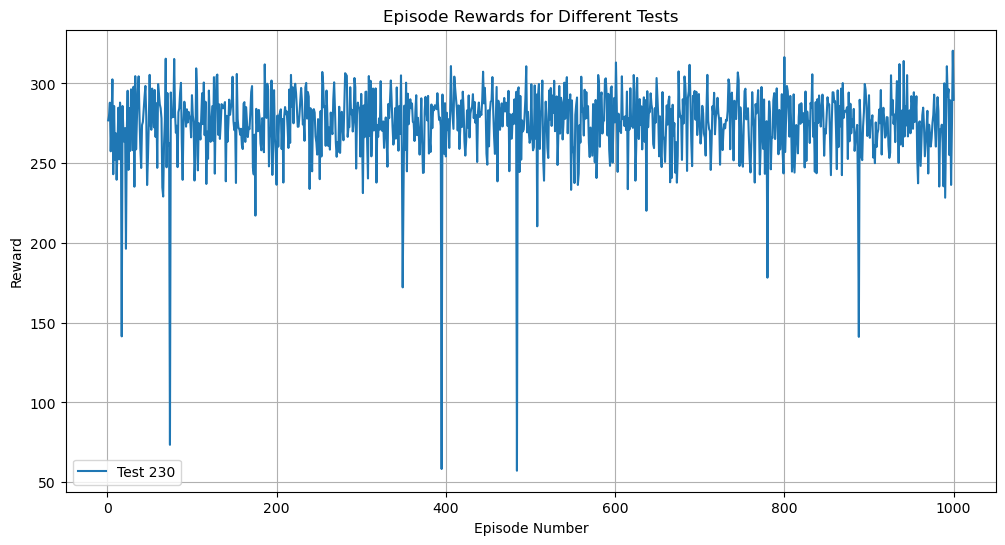

In [17]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
for test_name in test_list:
    plt.plot(range(1, num_test_episodes +1), test_rewards[test_name], label=f'Test {test_name}')

plt.xlabel('Episode Number')
plt.ylabel('Reward')
plt.title('Episode Rewards for Different Tests')
plt.legend()
plt.grid(True)
plt.show()

In [15]:
for test_name in test_list:
    print(f"{round(sum(test_rewards[test_name])/len(test_rewards[test_name]), 2)} & ", end="")

259.52 & 274.99 & 275.17 & 267.3 & 254.53 & 

In [ ]:
print(test_list)

: 